# Applied ML

We will apply Machine Learning to an interesting dataset about soccer players and referees.
The work will be divided in two parts, first a pre-processing + visualization pipeline to get comfortable with the data, and finally the prediction tasks, where the color of the skin of players will be inferered from other different parameters (features).

In [441]:
# A number of libraries will be used:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

## 1. Training a Random Forest Classifier

### 1.1 Pre-processing

In [442]:
#Loading the data to a DataFrame
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [443]:
# Just by descibing the data we notice how incomplete it is
df.describe()

/Users/nesara/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,145765.000000,143785.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,146028.000000,124621.000000,124621.000000,146028.000000,146028.000000,145865.000000,1.458650e+05,1.458650e+05,145865.000000,1.458650e+05,145865.000000
mean,181.935938,76.075662,2.921166,1.278344,0.708241,0.934581,0.338058,0.385364,0.011381,0.012559,0.264255,0.302862,1534.827444,29.642842,0.346276,1.969741e+04,6.310849e-04,0.452026,2.044023e+04,0.002994
std,6.738726,7.140906,3.413633,1.790725,1.116793,1.383059,0.906481,0.795333,0.107931,0.112889,0.295382,0.293020,918.736625,27.496189,0.032246,1.271262e+05,4.735857e-03,0.217469,1.306157e+05,0.019723
min,161.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,641.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1604.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,2345.000000,44.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,203.000000,100.000000,47.000000,29.000000,14.000000,18.000000,23.000000,14.000000,3.000000,2.000000,1.000000,1.000000,3147.000000,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


Having in mind that our final goal is to predict the skintone, we can already get rid of all the rows that don't have this. Also we need to create an aggregate of the two raters scores to act as our labels for classification.

In [444]:
df1 = df.dropna(axis=0, subset=['rater1', 'rater2'], how='any')

df1['Skintone']= np.round((df1['rater1'] + df1['rater2'])/2)
df1['Skintone_avg']= (df1['rater1'] + df1['rater2'])/2
df1.Skintone.value_counts()

/Users/nesara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/nesara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0    104714
1.0     19907
Name: Skintone, dtype: int64

There are many parameters that simply wont help to discriminate between skintone. We can dispose of them.

In [445]:
df1.drop('player', axis=1, inplace=True)      #The name is no use, we keep playerShort as the identifier
df1.drop('photoID', axis=1, inplace=True)     #Trash
df1.drop('rater1', axis=1, inplace=True)      #Not needed anymore
df1.drop('rater2', axis=1, inplace=True)      #Not needed anymore
df1.drop('refNum', axis=1, inplace=True)      #Referee should be independent or at most correlated through country
df1.drop('refCountry', axis=1, inplace=True)  #refCountry because it feels like cheating to look into the country of origin
df1.drop('Alpha_3', axis=1, inplace=True)     #Alpha_3 because it feels like cheating to look into the country of origin
df1.drop('meanIAT', axis=1, inplace=True)     #Because we are going to group by playerShort and referee data cannot be mixed
df1.drop('nIAT', axis=1, inplace=True)        #Because we are going to group by playerShort and referee data cannot be mixed
df1.drop('seIAT', axis=1, inplace=True)       #Because we are going to group by playerShort and referee data cannot be mixed
df1.drop('meanExp', axis=1, inplace=True)     #Because we are going to group by playerShort and referee data cannot be mixed
df1.drop('nExp', axis=1, inplace=True)        #Because we are going to group by playerShort and referee data cannot be mixed
df1.drop('seExp', axis=1, inplace=True)       #Because we are going to group by playerShort and referee data cannot be mixed

/Users/nesara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nesara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/nesara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/nesara/anaconda/lib/pytho

In [446]:
df1.head()

,playerShort,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,Skintone,Skintone_avg
0,lucas-wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,0.0,0.375
1,john-utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1.0,0.750
5,aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.0,0.125
6,aleksandar-kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.0,0.125
7,alexander-tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,1.0,1.000


In [447]:
df1.shape

(124621, 17)

In [448]:
#we eliminate all the rows with missing values of interest
df2 = df1.dropna(axis=0, how='any')
df2.shape

(115603, 17)

We have trashed around 10% of the data, but we believe it is acceptable as we still have over 100k entries left.

Now we will split the data in two, to make the aggregation by player easier. This is done separating sumable feature from those that are not summable. We asumme that the player remains in the same "club" (and the same "leagueCountry"  consequentially), with the same "position" for the entire season (2012-2013). We also assume honesty from the referees (no racism) which leads as to discard all the data related to the referee as it is assumed independent from the skintone.

In [449]:
#In both cases we keep the identifier
df_summable = df2.loc[:,["playerShort", "games", "victories", "ties", "defeats", "goals", "yellowCards", "yellowReds", "redCards"]]
df_non_summable = df2.loc[:,["playerShort", "club", "leagueCountry", "birthday", "height", "weight", "position", "Skintone", "Skintone_avg"]]

In [450]:
# And addition for the summables
df_g_summable = df_summable.groupby(['playerShort']).mean()
df_g_summable.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,
aaron-hughes,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000
aaron-hunt,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101
aaron-lennon,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000
aaron-ramsey,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615
abdelhamid-el-kaoutari,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054


In [451]:
# Simply drop duplicates for the non-summables
df_g_non_summable = df_non_summable.drop_duplicates(subset='playerShort', keep='first').set_index(['playerShort'])
df_g_non_summable.sort_index().head()

,club,leagueCountry,birthday,height,weight,position,Skintone,Skintone_avg
playerShort,,,,,,,,
aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,0.0,0.125
aaron-hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,0.0,0.125
aaron-lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,0.0,0.250
aaron-ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,0.0,0.000
abdelhamid-el-kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,0.0,0.250


In [452]:
# We check that each has the same number of rows
print(df_g_summable.shape)
print(df_g_non_summable.shape)

(1419, 8)
(1419, 8)


In [453]:
# Merging the two again
df_by_player = pd.concat([df_g_non_summable, df_g_summable], axis=1, join='outer')
df_by_player.head()

,club,leagueCountry,birthday,height,weight,position,Skintone,Skintone_avg,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,0.0,0.125,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000
aaron-hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,0.0,0.125,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101
aaron-lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,0.0,0.250,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000
aaron-ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,0.0,0.000,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615
abdelhamid-el-kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,0.0,0.250,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054


An extra transformation that seems reasonable is to change the "birthday" parameter for an "age" parameter

In [454]:
## Transform to datetime and substract to the season's year when we collected the data
df_by_player['age'] = pd.to_datetime(df_by_player.birthday).map(lambda x: 2012 - x.year)
df_by_player.age.head()
## We can now drop the "birthday" parameter
df_by_player.drop('birthday', axis=1, inplace=True)
df_by_player.head()

,club,leagueCountry,height,weight,position,Skintone,Skintone_avg,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,age
aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,0.0,0.125,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,33
aaron-hunt,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,0.0,0.125,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,26
aaron-lennon,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,0.0,0.250,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,25
aaron-ramsey,Arsenal FC,England,178.0,76.0,Center Midfielder,0.0,0.000,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,22
abdelhamid-el-kaoutari,Montpellier HSC,France,180.0,73.0,Center Back,0.0,0.250,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,22


The final step is to transform categorical variables to dummy variables, that are more friendly to machine learning algorithms. An important note is that this greatly increases the number of features due to the huge number of clubs, and makes us vulnerable to the curse of dimensionality as well as overfitting.

In [455]:
data = pd.get_dummies(df_by_player)
data.head()

,height,weight,Skintone,Skintone_avg,games,victories,ties,defeats,goals,yellowCards,...,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger
aaron-hughes,182.0,71.0,0.0,0.125,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,183.0,73.0,0.0,0.125,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,165.0,63.0,0.0,0.250,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-ramsey,178.0,76.0,0.0,0.000,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,180.0,73.0,0.0,0.250,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A different approach that is also worth trying, and that aims to avoid the feature space explosion, is to go from categorical strings to numerical codes that can be handled by a random forest. The interpretability of the results can be however much more tricky.

In [456]:
cat_columns = df_by_player.select_dtypes(['object']).columns
cat_columns

Index(['club', 'leagueCountry', 'position'], dtype='object')

In [457]:
data1 = df_by_player
data1[cat_columns] = df_by_player[cat_columns].apply(lambda x: x.astype('category').cat.codes)
data1.head()

,club,leagueCountry,height,weight,position,Skintone,Skintone_avg,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,age
aaron-hughes,33,0,182.0,71.0,1,0.0,0.125,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,33
aaron-hunt,86,2,183.0,73.0,0,0.0,0.125,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,26
aaron-lennon,79,0,165.0,63.0,10,0.0,0.250,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,25
aaron-ramsey,6,0,178.0,76.0,3,0.0,0.000,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,22
abdelhamid-el-kaoutari,48,1,180.0,73.0,1,0.0,0.250,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,22


The data is ready. Now we can do some extra visualizations or go directry to the machine learning tasks

### 1.2 Random Forest Classifier

In [458]:
#Seed initialization for repeatability
np.random.seed(seed=42) #The answer is 42 ;)

Splitting the data into working blocks (for our two versions)

In [459]:
data_dummyvar = data.drop(['Skintone', 'Skintone_avg'], axis=1)   ## Dummy variables 
target_dummyvar = data.Skintone.values.tolist()

data_label = data1.drop(['Skintone', 'Skintone_avg'], axis=1)     ## Labels
target_label = data1.Skintone.values.tolist()

In [460]:
from sklearn.ensemble import RandomForestClassifier

'''
RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_s
plit=2,
  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
  max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, 
  n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)[source]

'''
rf = RandomForestClassifier()

### Effect of different parameters on overfitting

#### Number of estimators (decision trees) 
Random forest is itself a way of fighting against overfitting in a decission tree. By increasing the number of trees in the forest overfitting shoud decrease respectively.

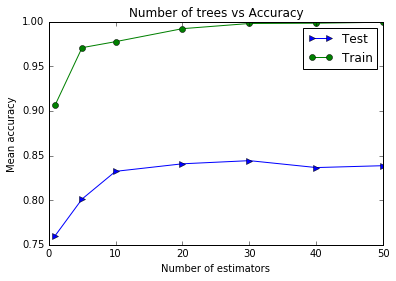

In [461]:
from sklearn.model_selection import GridSearchCV
'''
GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, 
    cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)[source])
'''
n_estimators = [1, 5, 10, 20, 30, 40, 50]
tuned_parameters = [{'n_estimators': n_estimators}]
clf = GridSearchCV(rf, tuned_parameters, cv=10)
clf.fit(data_label, target_label);

plt.plot(n_estimators, clf.cv_results_['mean_test_score'], 'b>-', n_estimators, clf.cv_results_['mean_train_score'],'go-');
plt.title('Number of trees vs Accuracy');
plt.xlabel('Number of estimators'); plt.ylabel('Mean accuracy'); plt.legend(['Test','Train']);

#### Maximum depth of the trees
Another easy way to control overfitting in a random fores is by regulating the maximum depth the trees can take. We expect that overfitting will be reduced as the maximum depth of the trees is decreased.

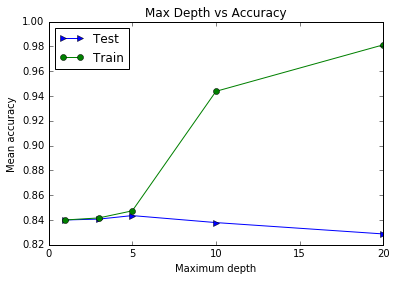

In [462]:
rf = RandomForestClassifier(n_estimators=10) 
max_depth = [1, 3, 5, 10, 20]
tuned_parameters = [{'max_depth': max_depth}]
clf = GridSearchCV(rf, tuned_parameters, cv=10)
clf.fit(data_label, target_label);

plt.plot(max_depth, clf.cv_results_['mean_test_score'], 'b>-')
plt.plot(max_depth, clf.cv_results_['mean_train_score'], 'go-');
plt.title('Max Depth vs Accuracy'); plt.legend( ('Test', 'Train'), loc='upper left')
plt.xlabel('Maximum depth'); plt.ylabel('Mean accuracy'); 

Practically flat after the very first split!

#### Minimum number of samples required to be at a leaf node

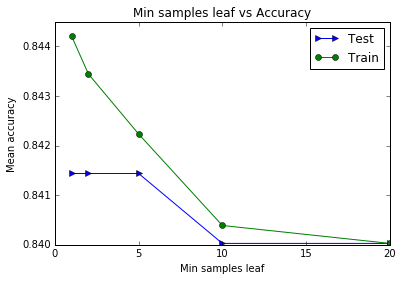

In [463]:
rf = RandomForestClassifier(n_estimators=30, max_depth=5) 
min_samples_leaf = [1, 2, 5, 10, 20]
tuned_parameters = [{'min_samples_leaf': min_samples_leaf}]
clf = GridSearchCV(rf, tuned_parameters, cv=40)
clf.fit(data_label, target_label);

plt.plot(min_samples_leaf, clf.cv_results_['mean_test_score'], 'b>-')
plt.plot(min_samples_leaf, clf.cv_results_['mean_train_score'], 'go-');
plt.title('Min samples leaf vs Accuracy'); plt.legend( ('Test', 'Train'), loc='upper right')
plt.xlabel('Min samples leaf'); plt.ylabel('Mean accuracy'); 

### Confusion Matrix

In [473]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=30, max_depth=5) 
predicted = cross_val_predict(rf, data_label, target_label, cv=10)
confusion_matrix(y_true=target_label, y_pred=predicted, labels=None, sample_weight=None)

array([[1191,    1],
       [ 225,    2]])

### Feature importance

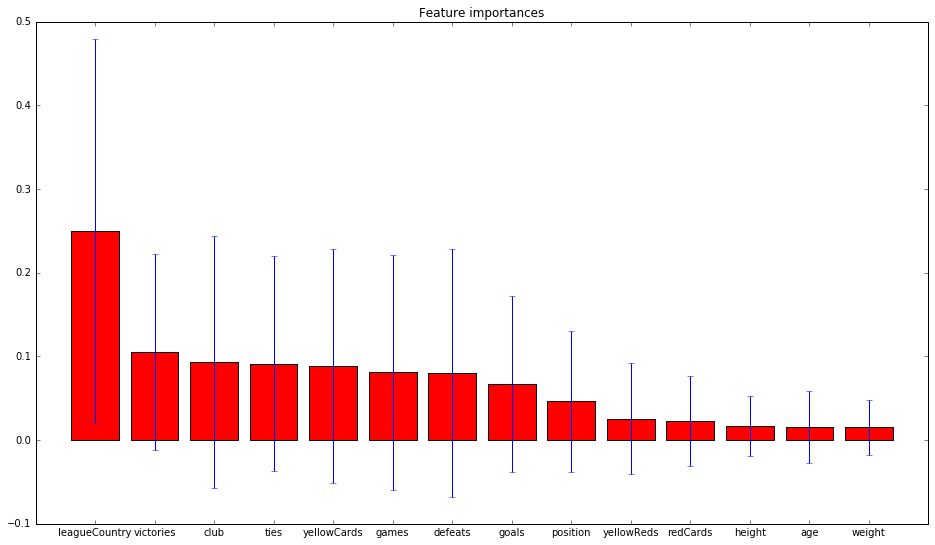

In [464]:
rf = RandomForestClassifier(n_estimators=30, max_depth=3)
rf.fit(data_label, target_label)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
X = data_label
features = np.asarray(data_label.columns.tolist())

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices])
plt.xlim([-1, X.shape[1]])
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.show()

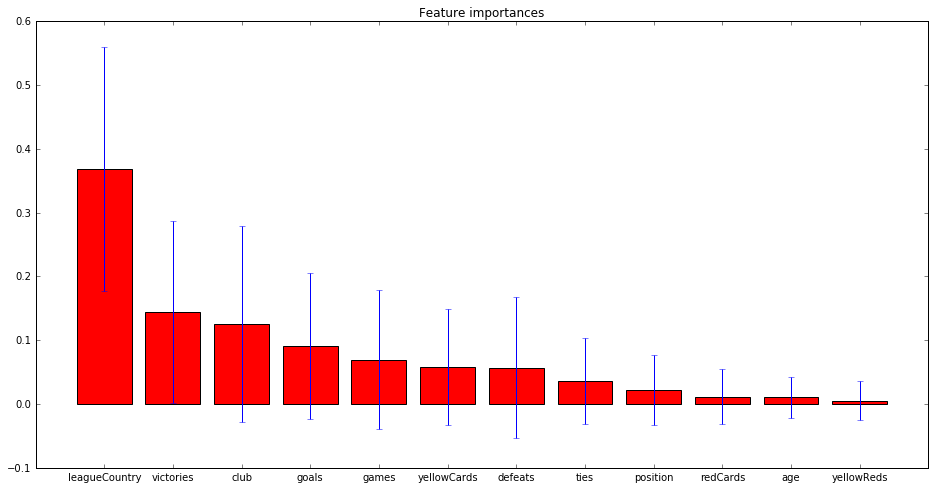

In [465]:
data_drop = data_label.drop(['height','weight'], axis=1)

rf.fit(data_drop, target_label)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
X = data_drop
features = np.asarray(data_drop.columns.tolist())
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices])
plt.xlim([-1, X.shape[1]])
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

## Bonus

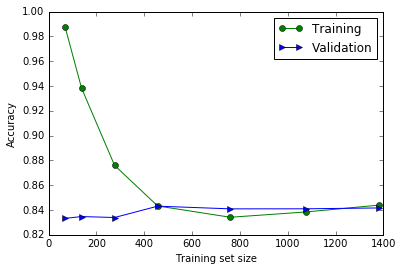

In [470]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

rf = RandomForestClassifier(n_estimators=30, max_depth=5)
predicted = cross_val_predict(rf, data_label, target_label, cv=10)
metrics.accuracy_score(target_label, predicted)

train_sizes, train_scores, valid_scores = learning_curve(rf, X=data_label, y=target_label, groups=None, 
                                                         train_sizes=np.array([ 0.05, 0.1, 0.2, 0.33, 0.55, 0.78, 1.]),
                                                         cv=40, scoring=None, exploit_incremental_learning=False,
                                                         n_jobs=1, pre_dispatch='all', verbose=0)
plt.plot(train_sizes, np.mean(train_scores,axis=1), 'go-')
plt.plot(train_sizes, np.mean(valid_scores,axis=1), 'b>-')
plt.legend(('Training','Validation'))
plt.xlabel('Training set size'); plt.ylabel('Accuracy')
plt.show()

[TODO: Find set of parameters which leads to high bias]
[Debug: Why is validation error less than training error in the figure below?]

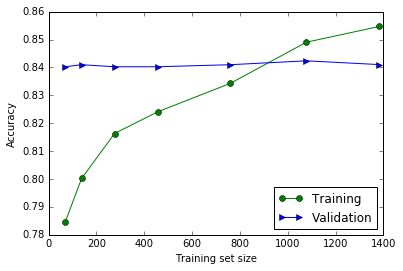

In [471]:
rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=10)
train_sizes, train_scores, valid_scores = learning_curve(rf, X=data_label, y=target_label, groups=None, 
                                                         train_sizes=np.array([ 0.05, 0.1, 0.2, 0.33, 0.55, 0.78, 1.]),
                                                         cv=40, scoring=None, exploit_incremental_learning=False,
                                                         n_jobs=1, pre_dispatch='all', verbose=0)
plt.plot(train_sizes, np.mean(train_scores,axis=1), 'go-')
plt.plot(train_sizes, np.mean(valid_scores,axis=1), 'b>-')
plt.legend(('Training','Validation'), loc='lower right')
plt.xlabel('Training set size'); plt.ylabel('Accuracy')
plt.show()

## 2 Unsupervised Learning 

In [468]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

n_clusters = 2
X = data_label
num_features = len(features)
silhouette_score_arr = []
mean_arr = []
std_arr = []

for i in range(num_features,0,-1):
    X = data_label[features[indices]].iloc[:,range(0,i)]
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("The average silhouette_score is :", np.round(silhouette_avg,3))
    silhouette_score_arr.append(silhouette_avg)
    
    df3 = pd.DataFrame({'Skintone': data1['Skintone_avg'], 'Cluster':cluster_labels})
    mean_arr.append(df3.groupby('Cluster').mean()['Skintone'].values)
    std_arr.append(df3.groupby('Cluster').std()['Skintone'].values)


The average silhouette_score is : 0.582
The average silhouette_score is : 0.582
The average silhouette_score is : 0.607
The average silhouette_score is : 0.607
The average silhouette_score is : 0.626
The average silhouette_score is : 0.626
The average silhouette_score is : 0.626
The average silhouette_score is : 0.627
The average silhouette_score is : 0.63
The average silhouette_score is : 0.63
The average silhouette_score is : 0.581
The average silhouette_score is : 0.742


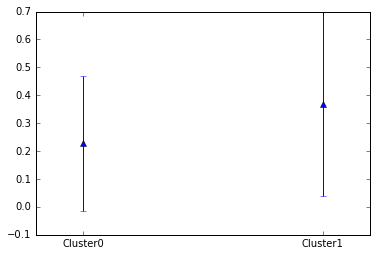

In [469]:
plt.errorbar([0, 1], mean_arr[-1], yerr=std_arr[-1], linestyle='None', marker='^')
plt.xlim([-0.2, 1.2]); 
plt.xticks([0,1],['Cluster0', 'Cluster1']); 
plt.show()